In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io.wavfile as wavfile
from scipy.io.wavfile import read
from scipy.stats import iqr
from scipy.stats import entropy as entr
import math

def mad(data, axis=None):
    return np.mean(abs(data - np.mean(data, axis)), axis)

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(x)//2:]

def analyze(file_name):
    fs, data = wavfile.read(file_name + '.wav')
    plt.plot(data)
    plt.show()

    file = open(file_name + '.txt','r') 
    words = file.read()
    file.close()

    words = words.split('\n')
    words_temp = []
    for word in words:
        words_temp.append(word.split('\t'))
    words = words_temp
    words_temp = []
    if words[-1][0] is '':
        words.pop()
    voices = []
    words[0][0]
    idx = 0
    prev_words = []
    for word in words:
        if word[2] in prev_words:
            continue
        data_temp = data[math.floor(float(word[0])*int(fs)) : math.floor(float(word[1])*int(fs))]
        data_min = min(data_temp)
        data_temp = [x - data_min for x in data_temp]
        data_max = max(data_temp)
        data_temp = [x/data_max for x in data_temp]
        voices.append([word[2], data_temp])
        prev_words.append(word[2])

    voices_features_dict = []
    voices_features_vec = []
    for voice in voices:    
        mean_value = np.mean(voice[1])
        std_value = np.std(voice[1])
        median_value = np.median(voice[1])
        energy_value = sum([x ** 2 for x in voice[1]]) / len(voice[1])
        interquartile_range = iqr(voice[1])
        entropy_value = entr(voice[1])
        autocorr_value = autocorr(voice[1])
        freq_sig = np.fft.fft(voice[1])
        max_fft_value = np.argmax(abs(freq_sig[1:]))
        skewness_value = scipy.stats.skew(abs(freq_sig[1:]))
        kurtosis_value = scipy.stats.kurtosis(abs(freq_sig[1:]))
        sma = sum(voice[1])
        mad_value = mad(voice[1])
       
        features_dict = {'mean': mean_value, 'std': std_value, 'mdn': median_value, 'mad': mad_value,
                         'enrg': energy_value,'itr': interquartile_range, 'entr': entropy_value, 'autocorr': autocorr_value,
                         'max_fft': max_fft_value, 'skewness': skewness_value, 'kurtosis': kurtosis_value, 'sma': sma }
        
        features_vec = [mean_value, std_value, median_value, energy_value, interquartile_range, entropy_value, autocorr_value,
                       max_fft_value, skewness_value, kurtosis_value, sma, mad_value]
        
        voices_features_vec.append([voice[0], features_vec])
        voices_features_dict.append([voice[0], features_dict])
    
    return voices_features_vec, voices_features_dict

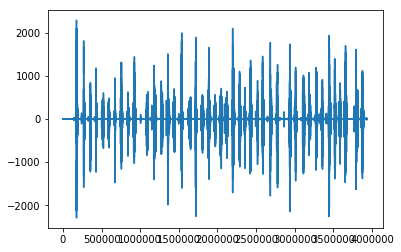

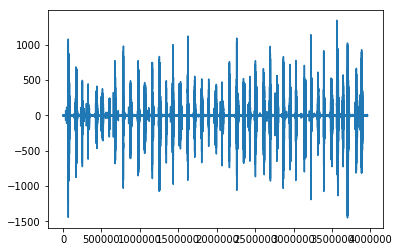

[['ZAPAL',
  {'mean': 0.50047094,
   'std': 0.052503627,
   'mdn': 0.50174826,
   'mad': 0.028203342,
   'enrg': 0.2532277575701218,
   'itr': 0.03081291913986206,
   'entr': 10.113157,
   'autocorr': array([3.1078171e+03, 3.1080542e+03, 3.1082976e+03, ..., 7.2582960e-01,
          4.8891640e-01, 2.4845156e-01], dtype=float32),
   'max_fft': 139,
   'skewness': 7.035939693450928,
   'kurtosis': 69.11207050733934,
   'sma': 12416.182690395042}],
 ['SWIATLO',
  {'mean': 0.46625733,
   'std': 0.059077136,
   'mdn': 0.46648952,
   'mad': 0.03232874,
   'enrg': 0.22088601858056647,
   'itr': 0.02369355410337448,
   'entr': 10.05645,
   'autocorr': array([2.5629302e+03, 2.5629316e+03, 2.5629236e+03, ..., 6.4173001e-01,
          4.2686313e-01, 2.1322666e-01], dtype=float32),
   'max_fft': 134,
   'skewness': 15.698958396911621,
   'kurtosis': 373.96114075953636,
   'sma': 10958.91260278807}],
 ['W',
  {'mean': 0.5915571,
   'std': 0.11267323,
   'mdn': 0.5929332,
   'mad': 0.07404596,
   'en

In [48]:
vec_1, dic_1 = analyze('273083_23_M_10_2')
vec_2, dic_2 = analyze('273083_23_M_13_3')

dic_1

C:\Users\wjl92z\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


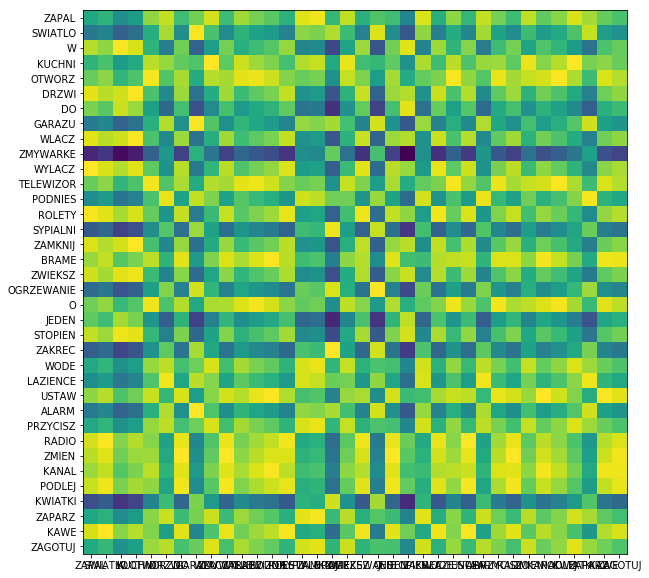

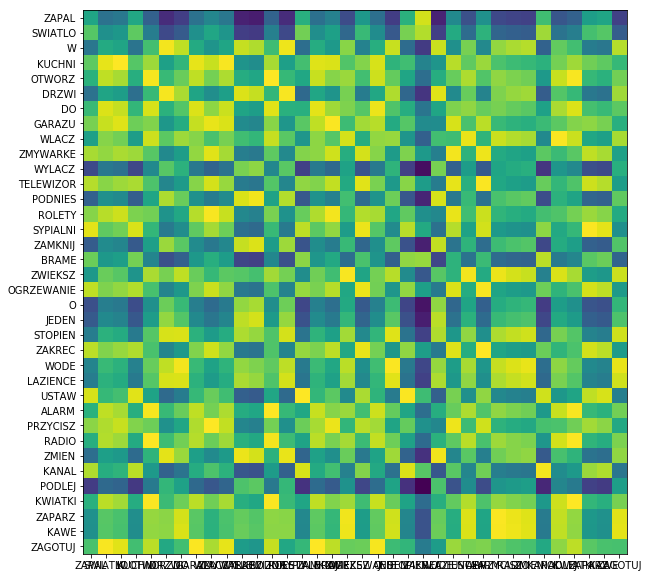

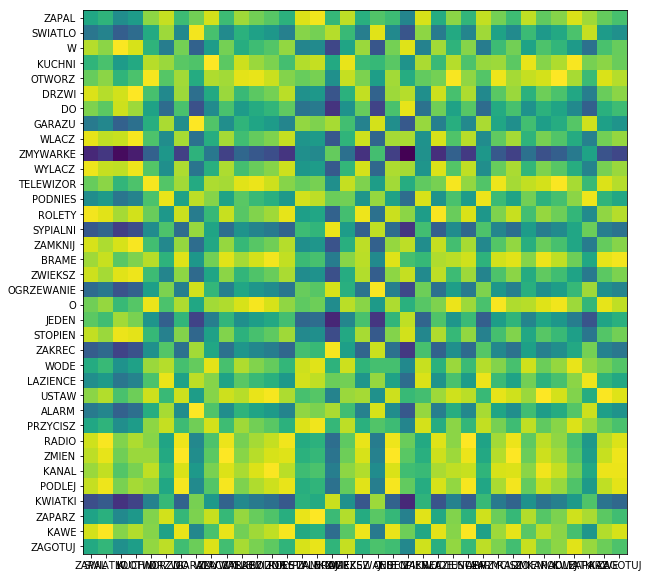

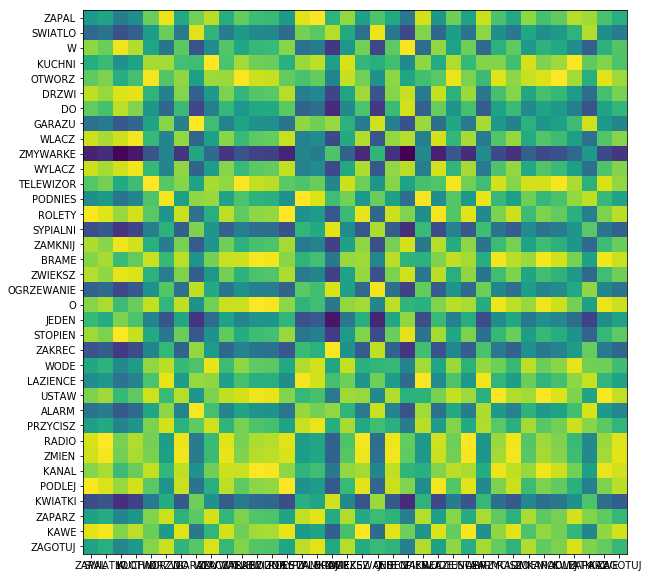

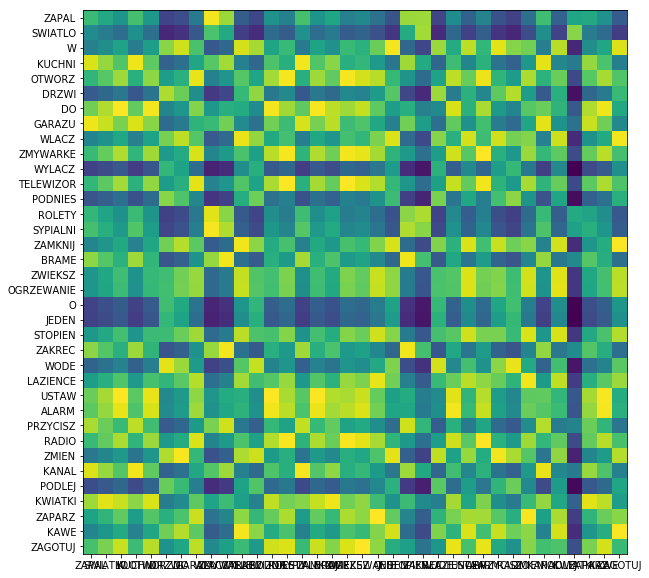

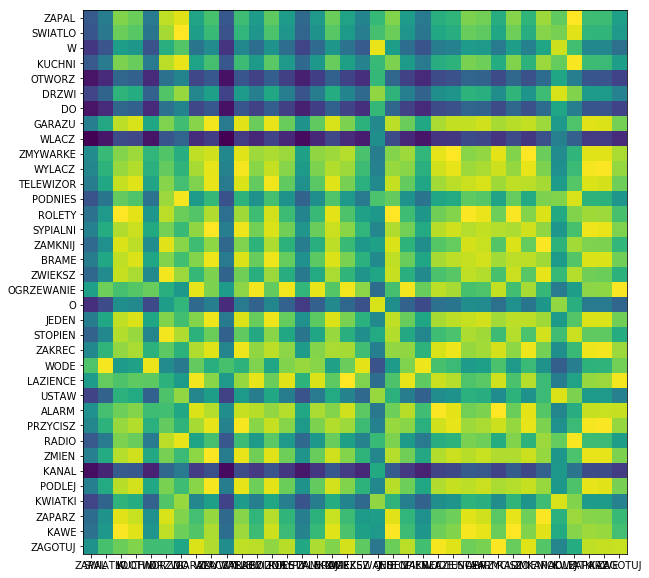

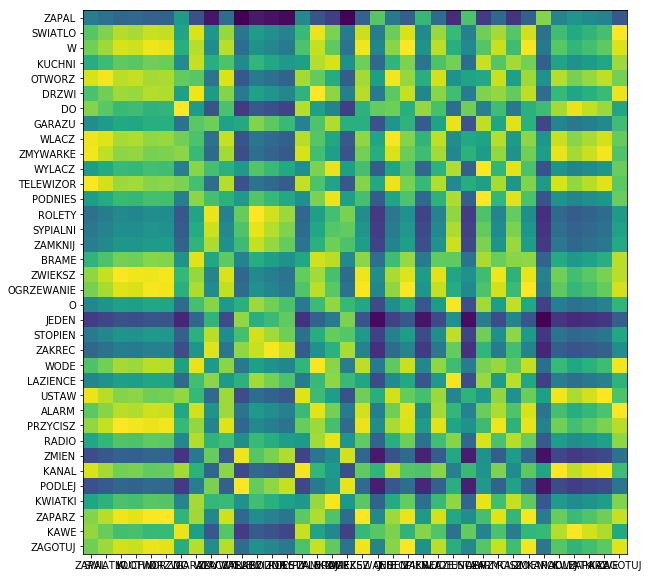

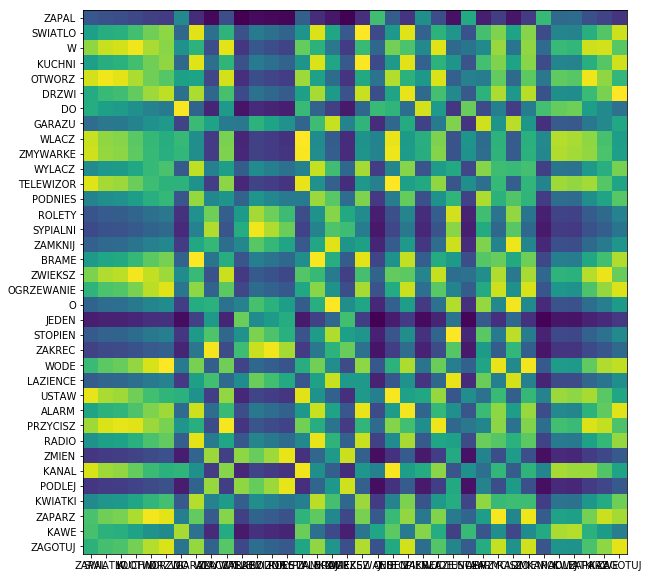

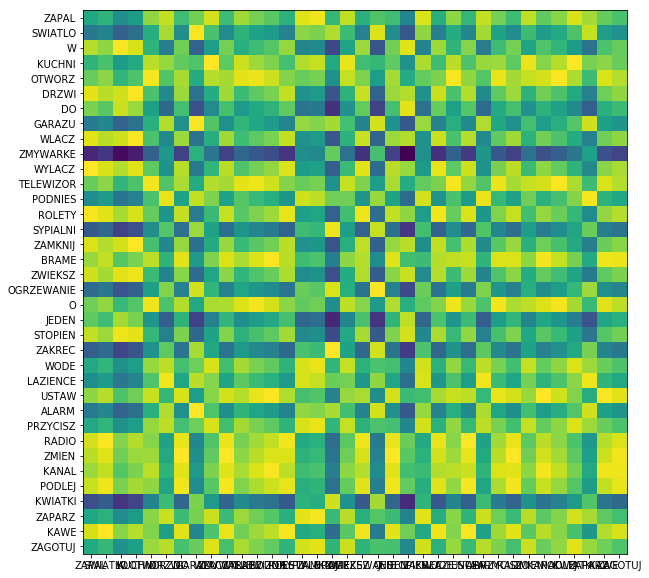

In [42]:
def show_similarity(vf1, vf2, feature):
    if feature is 'all':
        features = ['mean', 'std', 'mdn', 'enrg', 'itr', 'max_fft', 'skewness', 'kurtosis']
        for f in features:
            diff = []
            for feat_1 in vf1:
                val_1 = feat_1[1].get(f)
                vec = []
                idx = 0
                for feat_2 in vf2:
                    val_2 = feat_2[1].get(f)
                    if val_1 > val_2:
                        if idx + 1 not in range(len(vec)):
                            vec.append(val_2/val_1)
                        else:
                            vec[idx] += val_2/val_1
                            vec[idx] = vec[idx]/2
                    else:
                        if idx + 1 not in range(len(vec)):
                            vec.append(val_1/val_2)
                        else:
                            vec[idx] += val_1/val_2
                            vec[idx] = vec[idx]/2
                    idx = idx + 1
                diff.append(vec)
            fig, ax = plt.subplots()
            plt.imshow(diff)
            labels = []
            for x in vf1:
                labels.append(x[0])
            ax.set_xticklabels(labels)
            ax.set_yticklabels(labels)
            ax.set_xticks(np.arange(len(labels)))
            ax.set_yticks(np.arange(len(labels)))
            fig.set_size_inches(10, 10, forward=True)
            fig.show(diff)
            return
        
    diff = []
    for feat_1 in vf1:
        vec = [];
        val_1 = feat_1[1].get(feature)
        for feat_2 in vf2:
            val_2 = feat_2[1].get(feature)
            if val_1 > val_2:
                vec.append(val_2/val_1)
            else:
                vec.append(val_1/val_2)
        diff.append(vec)
    
    fig, ax = plt.subplots()
    plt.imshow(diff)
    labels = []
    for x in vf1:
        labels.append(x[0])
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    fig.set_size_inches(10, 10, forward=True)
    fig.show(diff)

show_similarity(dic_1, dic_2, 'mean')
show_similarity(dic_1, dic_2, 'std')
show_similarity(dic_1, dic_2, 'mdn')
show_similarity(dic_1, dic_2, 'enrg')
show_similarity(dic_1, dic_2, 'itr')
show_similarity(dic_1, dic_2, 'max_fft')
show_similarity(dic_1, dic_2, 'skewness')
show_similarity(dic_1, dic_2, 'kurtosis')
show_similarity(dic_1, dic_2, 'all')